In [1]:
import sys
import os
from typing import List
sys.path.append("..")

In [2]:
from collections import defaultdict
import os
import gzip
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
from colour import Color

from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from diachr.diachromatic_interaction_set import DiachromaticInteractionSet
from diachr.diachromatic_interaction import DiachromaticInteraction

In [3]:
class Digest:
    """
    Represent a BED3 version of a digest
    """

    def __init__(self, chrom, begin, end):
        if not isinstance(chrom, str):
            raise ValueError("chrom must be string")
        if not isinstance(begin, int) and isinstance(end, int):
            raise ValueError("begin and end must be ints")
        self._chrom = chrom
        self._begin = begin
        self._end = end

    @property
    def chrom(self):
        return self._chrom

    @property
    def begin(self):
        return self._begin

    @property
    def end(self):
        return self._end

    def __repr__(self):
        return "Digest(%s:%d-%d)" % (self._chrom, self._begin, self._end)

    def __eq__(self, other):
        if isinstance(other, Digest):
            return ((self._chrom == other._chrom) and (self._begin == other._begin) and (self._end == other._end))
        else:
            return False

    def __ne__(self, other):
        return (not self.__eq__(other))

    def __hash__(self):
        return hash(self.__repr__())

In [4]:
class DirectedTadVisualizer:
    """
    This class coorrdinates the visualization of TADs, while showing directedness of interactions
    within each cell.
    """

    def __init__(self, i_file, t_file) -> None:
        if not isinstance(i_file, str) or not os.path.isfile(i_file):
            raise ValueError("Invalid directed interaction file {}".format(i_file))
        self._fname = i_file
        self._figure_size = 10
        c1 = '#1f77b4'  # blue
        c2 = 'green'  # green
        red = Color("red")
        self._colors = list(red.range_to(Color(c1), 100))
        
        print('[INFO] Reading cis-interactions and group them by chromosomes ...')
        self._d_inter_by_chrom_dict = dict()
        d_inter_set = DiachromaticInteractionSet(rpc_rule = 'ht')
        d_inter_set.parse_file(i_file = i_file, verbose = False)
        for d_inter in d_inter_set.interaction_list:
            if d_inter.chrA == d_inter.chrB:
                if d_inter.chrA not in self._d_inter_by_chrom_dict:
                    self._d_inter_by_chrom_dict[d_inter.chrA] = [d_inter]
                else:
                    self._d_inter_by_chrom_dict[d_inter.chrA].append(d_inter)                    
        for key, d_inter_list in self._d_inter_by_chrom_dict.items():
            print('\t' + key + ': ' + '{:,}'.format(len(d_inter_list)) + ' interactions')
        print('[INFO] ... done.')
        
        print('[INFO] Reading TAD regions and group them by chromosomes ...')
        self._tads_by_chrom_dict = dict()
        with open(t_file, 'rt') as fp:
            next(fp)
            for line in fp:
                c, s, e = line.rstrip().split('\t')
                
                if c not in self._tads_by_chrom_dict:
                    self._tads_by_chrom_dict[c] = [(int(s), int(e))]
                else:
                    self._tads_by_chrom_dict[c].append((int(s), int(e)))
        for key, tad_list in self._tads_by_chrom_dict.items():
            print('\t' + key + ': ' + '{:,}'.format(len(tad_list)) + ' TADs')
        print('[INFO] ... done.')
        

    def extract_interactions(self, chrom, begin, end):
        """
        Create reduced interaction file that only contains interactions within the region to be visualized.
        """
        
        # Check arguments
        if not isinstance(chrom, str):
            raise ValueError("chrom must be a string")
        if not isinstance(begin, int) or not isinstance(end, int):
            raise ValueError("begin and end must be integers")
            

            
        # Get reduced set of interactions
        inter_dict = defaultdict(DiachromaticInteraction)
        if chrom not in self._d_inter_by_chrom_dict:
            return inter_dict
        for d_inter in self._d_inter_by_chrom_dict[chrom]:
            
            # Only keep interactions completely within the region we want to visualize
            if d_inter.chrA != chrom or d_inter.fromA < begin or end < d_inter.toB:
                continue
            else:
                inter_dict[d_inter.key] = d_inter
            
        print("[INFO] Extracted {} interactions in range {}:{}-{}".format(len(inter_dict), chrom, begin, end))      
        return inter_dict

    def pos_to_coordinate(self, pos):
        return (pos - self._min) * self._factor
    
    def coordinate_to_pos(self, coordinate):
        (1/self._factor) * coordinate + self_min

    def digest_to_coordinates(self, digest):
        begin = self.pos_to_coordinate(digest.begin) 
        end = self.pos_to_coordinate(digest.end)
        return [begin, end]
    
    def tad_to_grey_triangle(self, start:int, end:int) -> PolygonPatch:
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        TANGENT_45 = math.tan(math.pi / 4)
        # bc is the point where lines from b and c meet
        midpoint_x = begin + 0.5 * (end - begin)
        # bc is the length of the segment from b to bc_x
        bc = midpoint_x - begin
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        poly = Polygon([(begin, 0), (midpoint_x, bc), (end, 0)])
        color = 'gray'
        return PolygonPatch(polygon=poly, color=color, alpha=0.25)
    
    def black_triangle_left(self, start:int, end:int):
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        midpoint_x = begin + 0.5 * (end - begin)
        bc = midpoint_x - begin
        poly = Polygon([(begin, 0), (begin, bc), (midpoint_x, bc)])
        color = 'black'
        return PolygonPatch(polygon=poly, color=color)
    
    def black_triangle_right(self, start:int, end:int):
        begin = self.pos_to_coordinate(start) 
        end = self.pos_to_coordinate(end)
        midpoint_x = begin + 0.5 * (end - begin)
        bc = midpoint_x - begin
        poly = Polygon([(midpoint_x, bc), (end, bc), (end, 0)])
        color = 'black'
        return PolygonPatch(polygon=poly, color=color)
    
    def interaction_to_polygon(self, d_inter, digest_to_coords, pp_alpha):
        if not isinstance(d_inter, DiachromaticInteraction):
            raise ValueError("Not an Interaction")
        if not isinstance(digest_to_coords, dict):
            raise ValueError("Not a dictionary")
        
        TANGENT_45 = math.tan(math.pi / 4)  # The lines go up at 45 degree angles
        # a,b,c,d are coordinates of the two digests on the X axis
        a = self.pos_to_coordinate(d_inter.fromA)
        b = self.pos_to_coordinate(d_inter.toA)
        c = self.pos_to_coordinate(d_inter.fromB)
        d = self.pos_to_coordinate(d_inter.toB)
        # bc is the point where lines from b and c meet
        bc_x = b + 0.5 * (c - b)
        # bc is the length of the segment from b to bc_x
        bc = bc_x - b
        # tan = opposite/adjacent
        # opposite = tan(45)*adjacent
        bc_y = TANGENT_45 * bc
        # ad is the point where lines from a and d meet
        ad_x = a + 0.5 * (d - a)
        ad = ad_x - a
        ad_y = TANGENT_45 * ad
        # ac is the point where lines from a and c meet
        ac_x = a + 0.5 * (c - a)
        ac = ac_x - a
        ac_y = TANGENT_45 * ac
        # bd is the point where lines from b and d meet
        bd_x = b + 0.5 * (d - b)
        bd = bd_x - b
        bd_y = TANGENT_45 * bd
        poly = Polygon([(bc_x, bc_y), (bd_x, bd_y), (ad_x, ad_y), (ac_x, ac_y)])
        icat = d_inter.get_category()
        if icat == 'DIX':
            color ='orangered' # default, for DIX
        elif icat == 'DI':
            color = 'orange'
        elif icat == 'UIR':
            color = 'green'
        else:
            color = 'gray'

        return PolygonPatch(polygon=poly, color=color, alpha=pp_alpha)
    

    def create_visualization(self,
                             chrom:str,
                             begin:int,
                             end:int,
                             inter_cat:str,
                             enr_cat_list:List,
                             inter_dict:defaultdict(DiachromaticInteraction)):
        """
        chr4	10154260	10155805	N	chr4	10361332	10367100	N	1:1
        """
        
        tads = self._tads_by_chrom_dict[chrom]
        
        if len(inter_dict) == 0:
            return 
            
        # Get list of interactions and digests
        digest_set = set()
        d_inter_list = []
        rp_total_list = []
        for d_inter in inter_dict.values():
            if d_inter.get_category() == inter_cat:
                digestA = Digest(chrom=d_inter.chrA, begin=d_inter.fromA, end=d_inter.toA)
                digestB = Digest(chrom=d_inter.chrB, begin=d_inter.fromB, end=d_inter.toB)
                digest_set.add(digestA)
                digest_set.add(digestB)
                d_inter_list.append(d_inter)
                rp_total_list.append(d_inter.rp_total)
                
        quantile_range = np.arange(0.1,1.1,0.1)         
        quantile_values = np.quantile(rp_total_list, quantile_range)
        print('[INFO] Read pair count quantiles:')
        print('\t[INFO] ' + str(quantile_values))
        print('\t[INFO] ' + str(str(quantile_range)))

        digest_list = list(digest_set)
        digest_list.sort(key=lambda x: x.begin, reverse=False)
        self._min = min([x.begin for x in digest_list])
        self._max = max([x.end for x in digest_list])
        self._span = self._max - self._min
        self._factor = self._figure_size / self._span
        print("[INFO] min: {} max: {}".format(self._min, self._max))
        digest_to_coords = defaultdict(list)
        for d in digest_list:
            digest_to_coords[d] = self.digest_to_coordinates(d)
        print("[INFO] Got {} digests".format(len(digest_set)))
        print("[INFO] Got {} interactions".format(len(d_inter_list)))
        fig = plt.figure(1, figsize=(15, 9))
        ax = fig.add_subplot(111)

        ax.set_title(inter_cat, loc='left', fontsize='x-large')
        ax.set_xlabel('Genomic coordinate', fontsize='x-large')
        print('[INFO] begin:' + str(begin))
        print('[INFO] end:' + str(end))
        print('[INFO] pos_to_coordinate(begin):' + str(self.pos_to_coordinate(begin)))
        print('[INFO] pos_to_coordinate(end):' + str(self.pos_to_coordinate(end)))
        xrange = [self.pos_to_coordinate(begin), self.pos_to_coordinate(end)]
        yrange = [0, 0.5 * (self.pos_to_coordinate(end) - self.pos_to_coordinate(begin))]
        ax.set_xlim(xrange)
        ax.set_ylim(yrange)
        
        ## Plot the TADs
        for mytuple in tads:
            polypatch = self.tad_to_grey_triangle(start=mytuple[0], end=mytuple[1])
            ax.add_patch(polypatch)
                       
       # Plot the interaction polygons
        for d_inter in d_inter_list:
            i_cat = d_inter.get_category()
            e_cat = d_inter.enrichment_status_tag_pair
            if i_cat == inter_cat and e_cat in enr_cat_list:
                i = 1
                pp_alpha = 0.0
                for i in range(0, 10):
                    if quantile_values[i] < d_inter.rp_total:
                        pp_alpha = quantile_range[i]
                #print(str(d_inter.rp_total) + '\t' + str(pp_alpha))
                polypatch = self.interaction_to_polygon(d_inter=d_inter, digest_to_coords=digest_to_coords, pp_alpha=pp_alpha)                
                ax.add_patch(polypatch)
                
        # Plot black triangles
        polypatch = self.black_triangle_left(start=begin, end=end)
        ax.add_patch(polypatch)
        polypatch = self.black_triangle_right(start=begin, end=end)
        ax.add_patch(polypatch)
        
                
        # ax.set_xticks(range(*xrange) + [xrange[-1]])
        # ax.set_ylim(*yrange)
        # ax.set_yticks(range(*yrange) + [yrange[-1]])
        ax.set_aspect(1)
        plt.show()


In [17]:
#INTERACTION_FILE = '/Users/robinp/Downloads/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/HC/20000/JAV_ALL_HC_RALL_ALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions.tsv.gz'

#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/CHC/JAV_MK_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz'
INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MK_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions.tsv.gz'

#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR005/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.05_evaluated_and_categorized_interactions_chr10.tsv.gz'
#INTERACTION_FILE = '/Users/hansep/PycharmProjects/diachrscripts/DICer_interactions/HT/FDR001/CHC/JAV_MAC_M0_RALT_20000_ht_fdr0.01_evaluated_and_categorized_interactions_chr10.tsv.gz'

CELL_TYPE_SHORT = 'MK'
TAD_BED_FILE = '../additional_files/javierre_2016/tad_regions_hg38/hglft_genome_TADs_' + CELL_TYPE_SHORT + '_hg38.bed'
#TAD_BED_FILE = '../additional_files/javierre_2016/tad_regions_hg38/all_tad_regions.bed'

In [18]:
visualizer = DirectedTadVisualizer(i_file=INTERACTION_FILE, t_file=TAD_BED_FILE)

[INFO] Reading cis-interactions and group them by chromosomes ...
	chr1: 598,046 interactions
	chr11: 354,002 interactions
	chr4: 309,656 interactions
	chr6: 363,262 interactions
	chr5: 354,305 interactions
	chr2: 490,432 interactions
	chrX: 154,641 interactions
	chr9: 238,366 interactions
	chr12: 326,426 interactions
	chr10: 265,812 interactions
	chr3: 420,267 interactions
	chr14: 218,642 interactions
	chr13: 155,564 interactions
	chr8: 274,319 interactions
	chr22: 75,687 interactions
	chr19: 114,161 interactions
	chr18: 112,301 interactions
	chr7: 278,988 interactions
	chr16: 130,929 interactions
	chr17: 198,701 interactions
	chr21: 74,629 interactions
	chr20: 140,042 interactions
	chr15: 170,694 interactions
	chrY: 909 interactions
[INFO] ... done.
[INFO] Reading TAD regions and group them by chromosomes ...
	chr1: 309 TADs
	chr10: 146 TADs
	chr11: 182 TADs
	chr12: 176 TADs
	chr13: 112 TADs
	chr14: 116 TADs
	chr15: 137 TADs
	chr16: 86 TADs
	chr17: 104 TADs
	chr18: 88 TADs
	chr19: 39

In [44]:
chrom = 'chr10'
begin = 10500000
end = begin + 5000000
inter_dict = visualizer.extract_interactions(chrom=chrom, begin=begin, end=end)

[INFO] Extracted 13269 interactions in range chr10:10500000-15500000


[INFO] Read pair count quantiles:
	[INFO] [  44.   53.   66.   78.   91.  108.  129.  162.  220. 1138.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10527882 max: 15426857
[INFO] Got 872 digests
[INFO] Got 1496 interactions
[INFO] begin:10500000
[INFO] end:15500000
[INFO] pos_to_coordinate(begin):-0.05691394628468199
[INFO] pos_to_coordinate(end):10.149302660250358


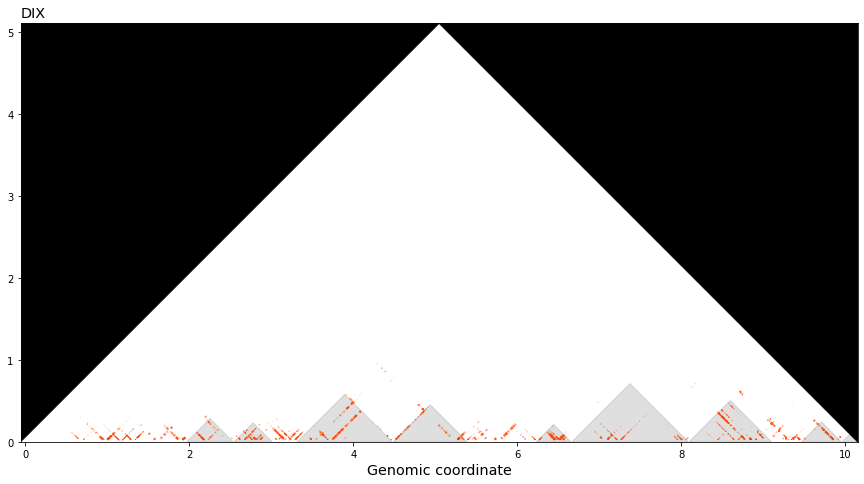

In [45]:
visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DIX',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  25.  32.  43.  65. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10500092 max: 15487304
[INFO] Got 1290 digests
[INFO] Got 5587 interactions
[INFO] begin:10500000
[INFO] end:15500000
[INFO] pos_to_coordinate(begin):-0.00018447180508869484
[INFO] pos_to_coordinate(end):10.02545710910224


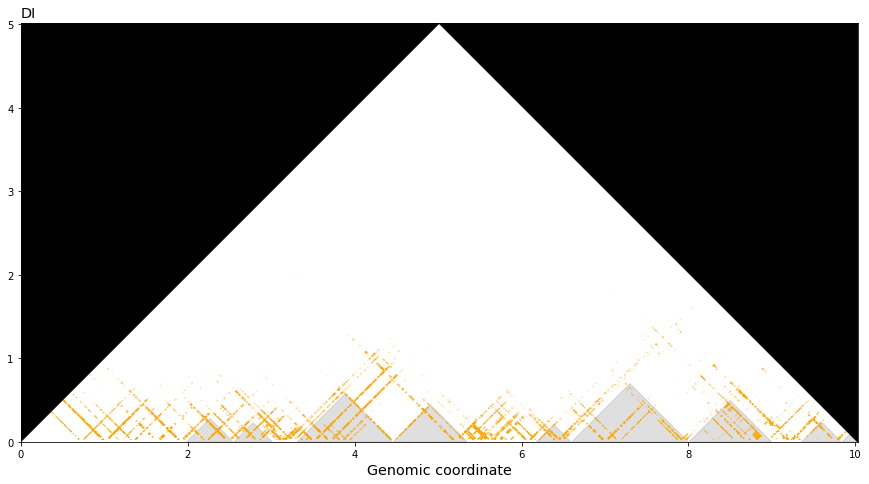

In [46]:
visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  30.  40.  59. 414.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10500092 max: 15497956
[INFO] Got 1165 digests
[INFO] Got 3978 interactions
[INFO] begin:10500000
[INFO] end:15500000
[INFO] pos_to_coordinate(begin):-0.00018407863839432203
[INFO] pos_to_coordinate(end):10.004089747139977


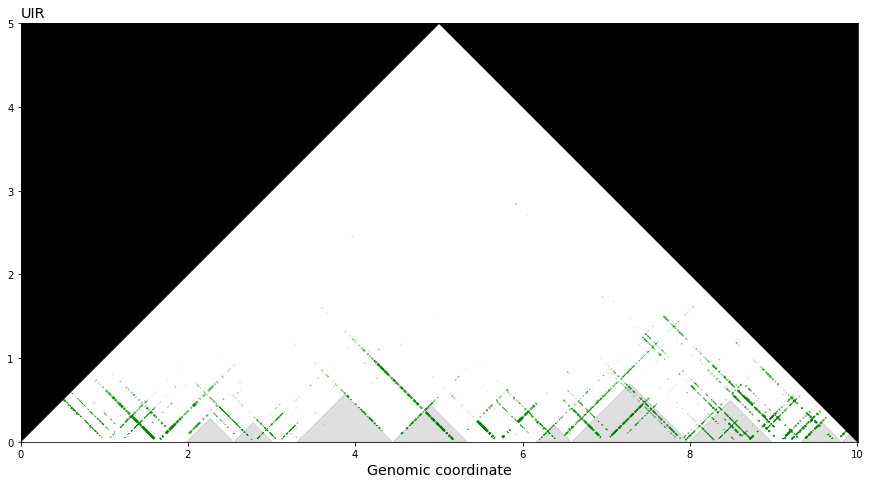

In [48]:
visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='UIR',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)

[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10500092 max: 15497956
[INFO] Got 1016 digests
[INFO] Got 2208 interactions
[INFO] begin:10500000
[INFO] end:15500000
[INFO] pos_to_coordinate(begin):-0.00018407863839432203
[INFO] pos_to_coordinate(end):10.004089747139977


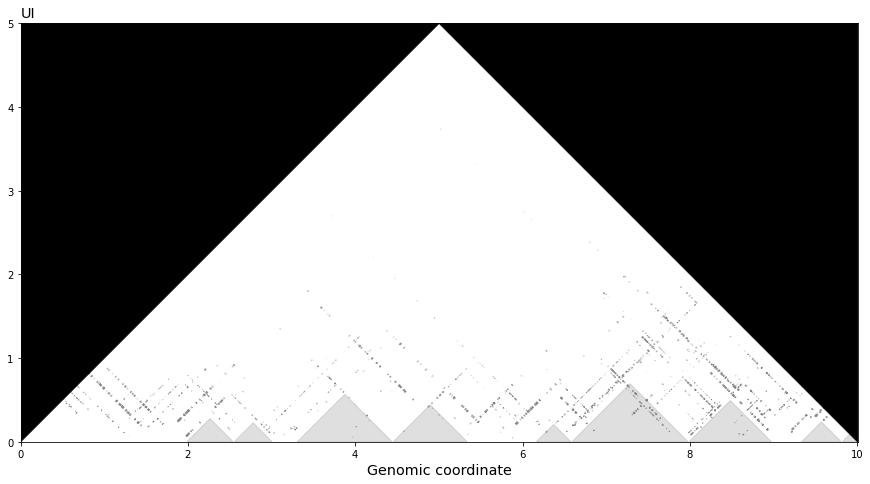

In [49]:
visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='UI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)

[INFO] Extracted 9312 interactions in range chr10:5000000-10000000
[INFO] Read pair count quantiles:
	[INFO] [ 38.   49.   57.   67.   81.  102.  126.  152.4 219.  879. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 5010703 max: 9300384
[INFO] Got 486 digests
[INFO] Got 759 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):-0.02495057324775432
[INFO] pos_to_coordinate(end):11.630927800925058


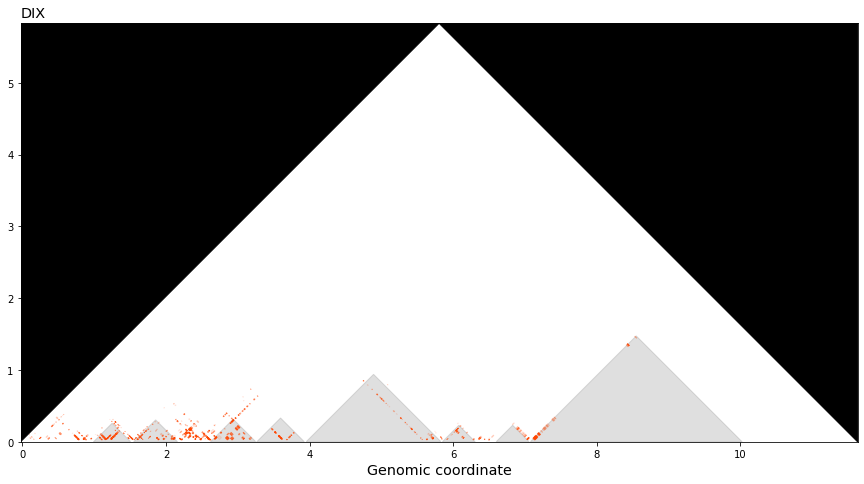

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  24.  29.  38.  57. 315.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 5008247 max: 9856129
[INFO] Got 1100 digests
[INFO] Got 3205 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):-0.017011552673930595
[INFO] pos_to_coordinate(end):10.296770837243976


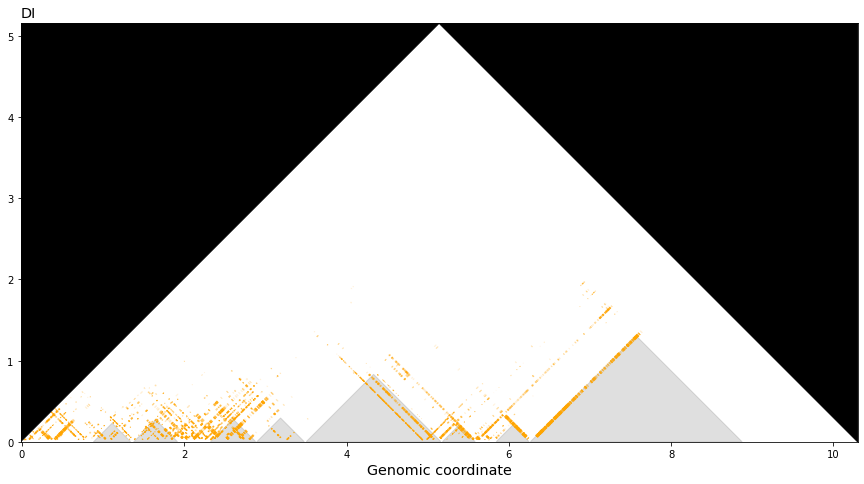

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  17.  21.  25.  32.  44.  72. 552.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 5008247 max: 9917673
[INFO] Got 964 digests
[INFO] Got 3598 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):-0.01679829780507945
[INFO] pos_to_coordinate(end):10.16769170163681


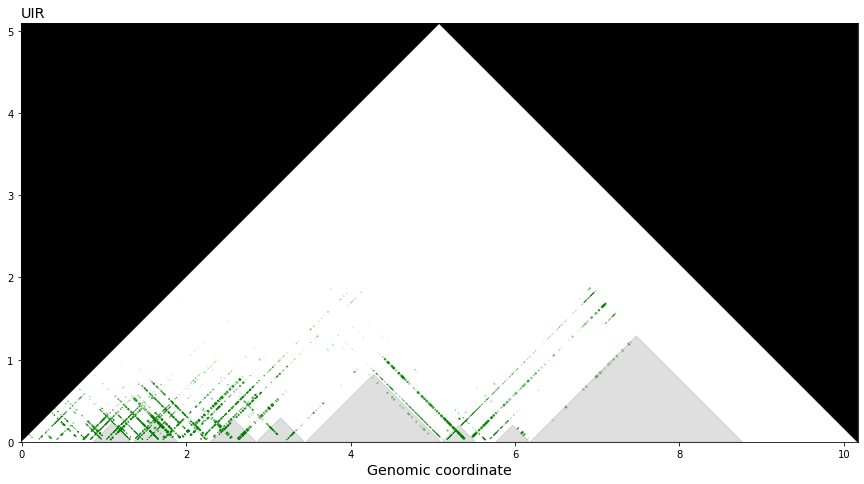

[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 11. 11. 12. 13. 15. 19. 31.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 5011026 max: 9979002
[INFO] Got 890 digests
[INFO] Got 1750 interactions
[INFO] begin:5000000
[INFO] end:10000000
[INFO] pos_to_coordinate(begin):-0.02219414908606644
[INFO] pos_to_coordinate(end):10.042266709823075


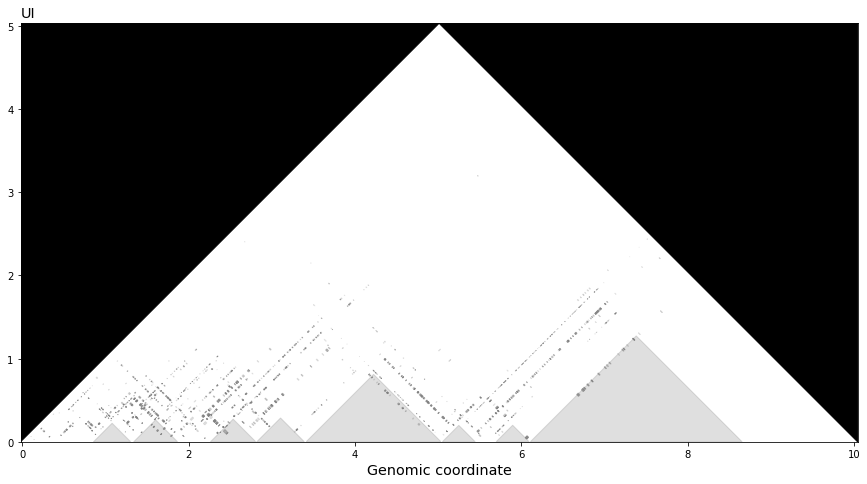

[INFO] Extracted 7749 interactions in range chr10:7500000-12500000
[INFO] Read pair count quantiles:
	[INFO] [ 43.   53.   63.   76.   89.  106.  129.7 162.  212.9 530. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 7501741 max: 12494236
[INFO] Got 448 digests
[INFO] Got 702 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):-0.0034872343387424526
[INFO] pos_to_coordinate(end):10.01154532953964


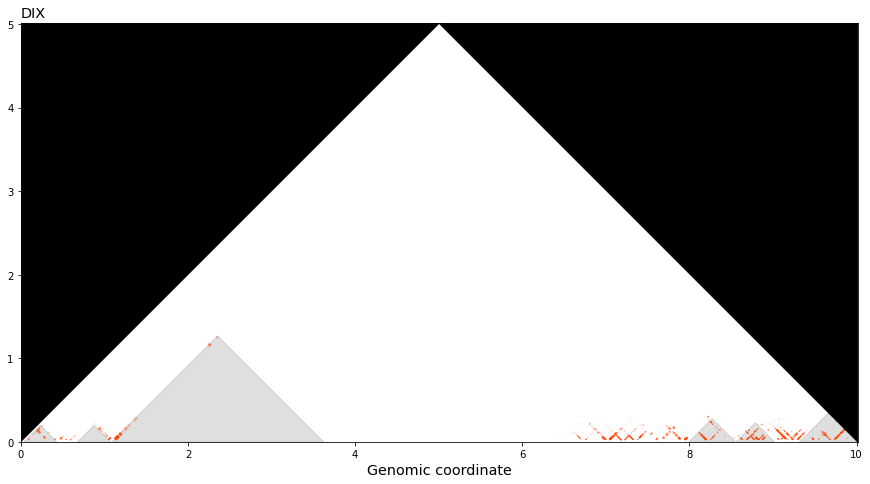

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  19.  23.  28.  37.  56. 376.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 7501741 max: 12494236
[INFO] Got 1265 digests
[INFO] Got 3589 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):-0.0034872343387424526
[INFO] pos_to_coordinate(end):10.01154532953964


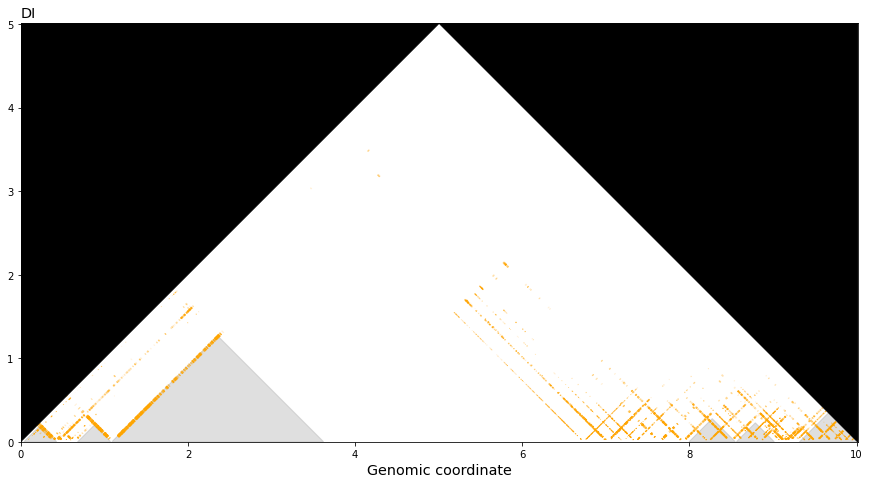

[INFO] Read pair count quantiles:
	[INFO] [ 10.   11.   13.   15.   17.   21.   25.   32.2  50.  360. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 7501741 max: 12487936
[INFO] Got 1044 digests
[INFO] Got 2090 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):-0.003491640419197404
[INFO] pos_to_coordinate(end):10.024194801847903


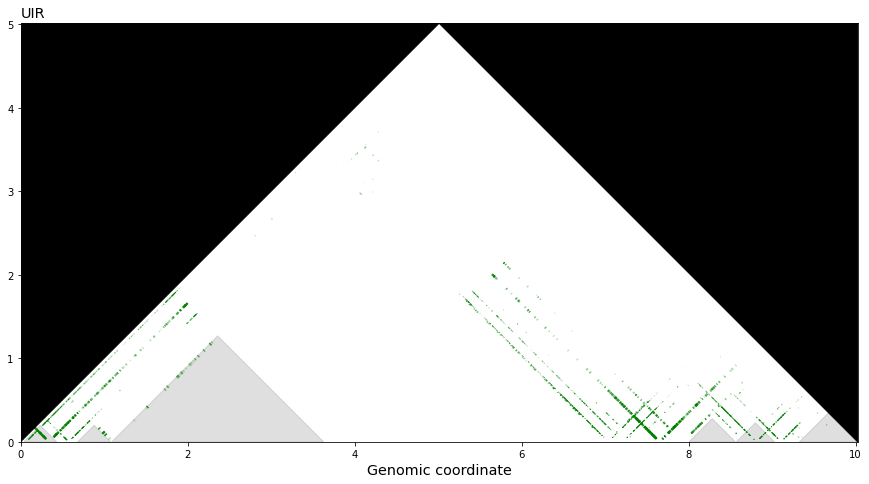

[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 7501741 max: 12494236
[INFO] Got 918 digests
[INFO] Got 1368 interactions
[INFO] begin:7500000
[INFO] end:12500000
[INFO] pos_to_coordinate(begin):-0.0034872343387424526
[INFO] pos_to_coordinate(end):10.01154532953964


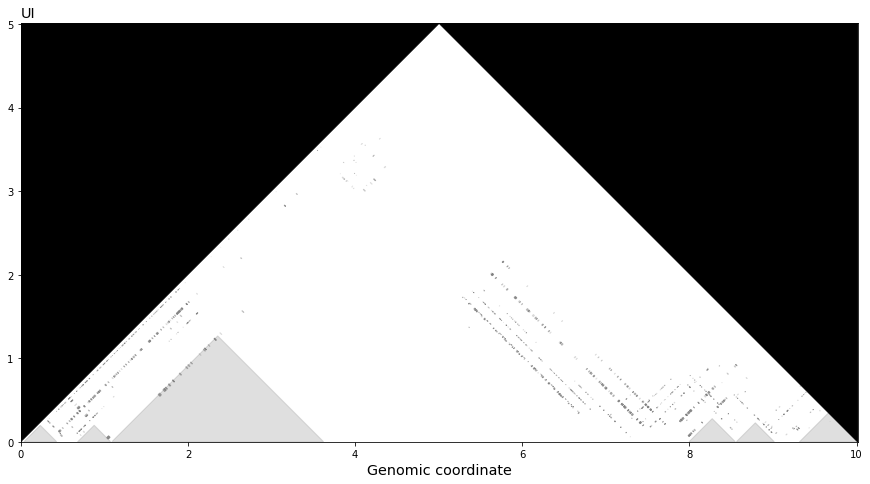

[INFO] Extracted 11832 interactions in range chr10:10000000-15000000
[INFO] Read pair count quantiles:
	[INFO] [  44.    53.    65.    77.    90.   107.   128.   161.   211.8 1138. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10527882 max: 14968789
[INFO] Got 803 digests
[INFO] Got 1353 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):-1.188680600607038
[INFO] pos_to_coordinate(end):10.070280688156721


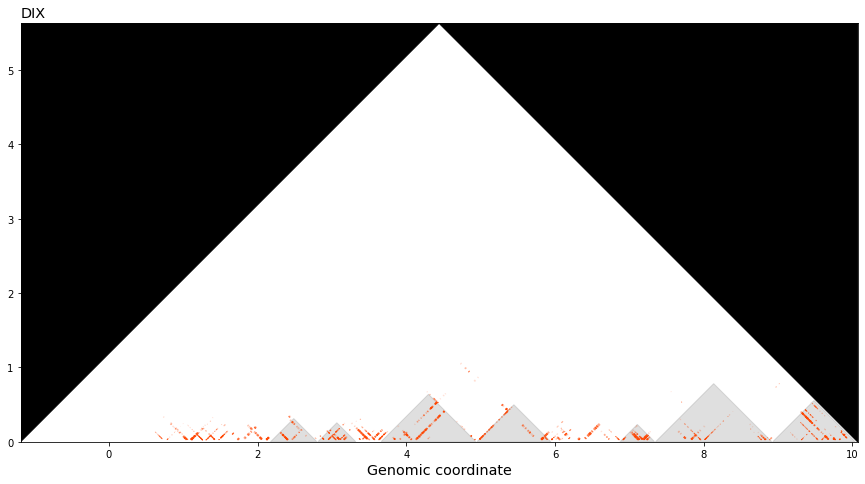

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  41.  62. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10003478 max: 14998679
[INFO] Got 1320 digests
[INFO] Got 5391 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):-0.006962682782935062
[INFO] pos_to_coordinate(end):10.002644538227791


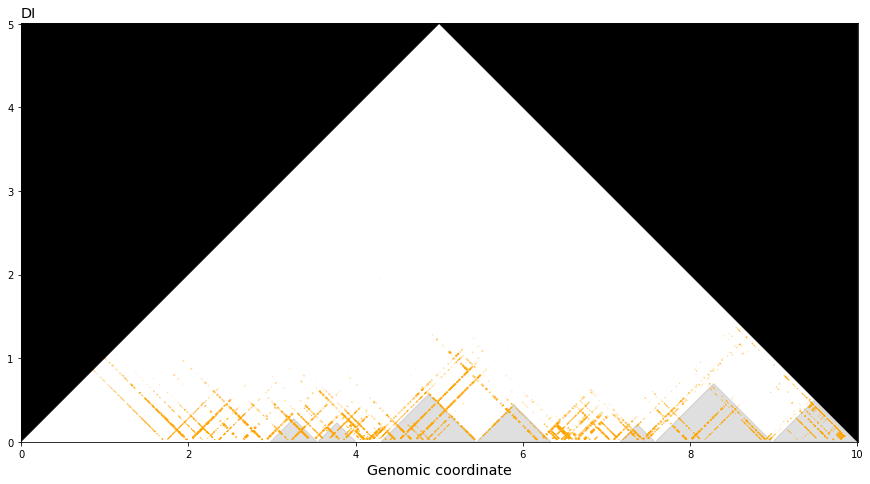

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  16.  20.  24.  30.  39.  60. 414.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10004154 max: 14968789
[INFO] Got 1170 digests
[INFO] Got 3210 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):-0.008367181071720279
[INFO] pos_to_coordinate(end):10.062866655856876


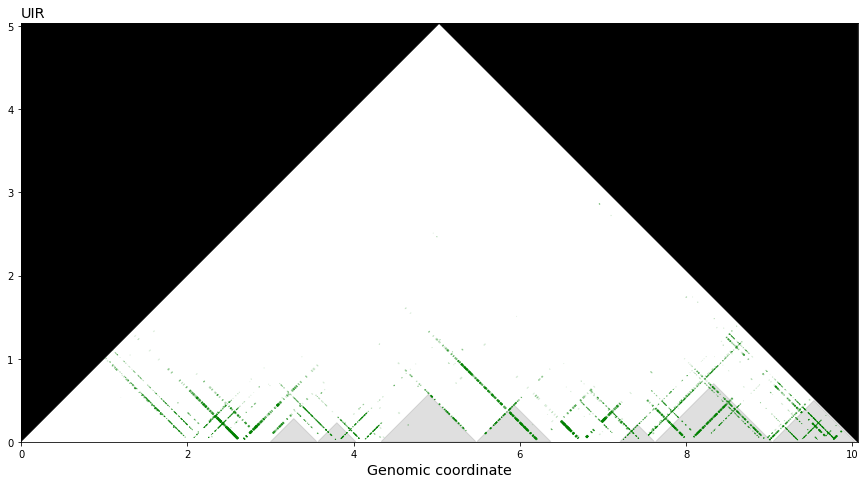

[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 11. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 10003478 max: 14968789
[INFO] Got 1012 digests
[INFO] Got 1878 interactions
[INFO] begin:10000000
[INFO] end:15000000
[INFO] pos_to_coordinate(begin):-0.007004596489525026
[INFO] pos_to_coordinate(end):10.062858096904705


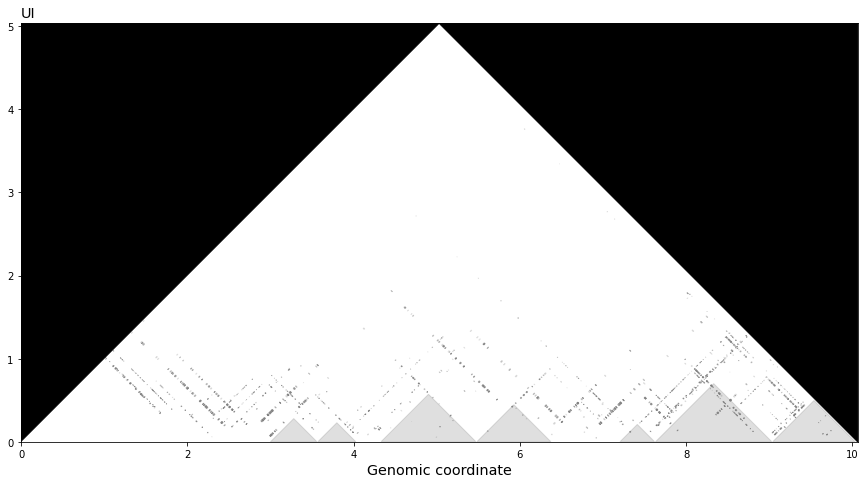

[INFO] Extracted 12622 interactions in range chr10:12500000-17500000
[INFO] Read pair count quantiles:
	[INFO] [  45.    55.    67.    77.    91.   107.   126.   155.   204.1 1138. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 12533551 max: 17496976
[INFO] Got 797 digests
[INFO] Got 1340 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):-0.06759646816462422
[INFO] pos_to_coordinate(end):10.006092567128544


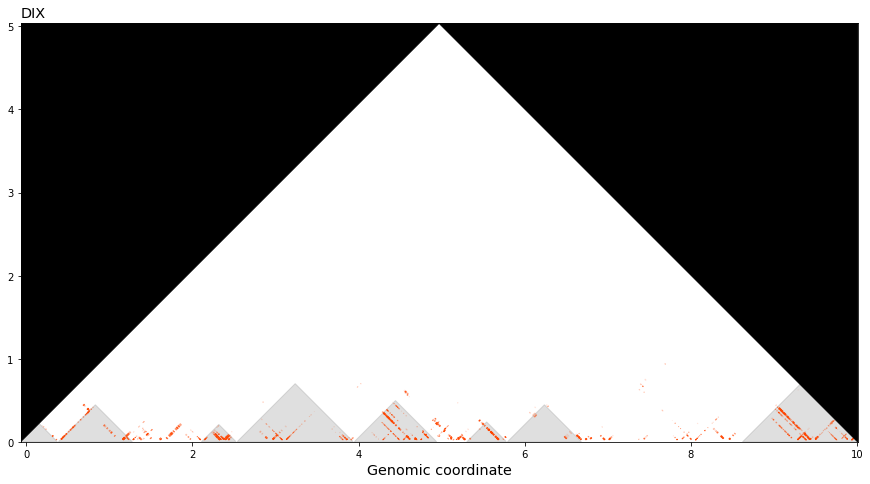

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  21.  27.  36.  49.  73. 583.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 12500984 max: 17497516
[INFO] Got 1265 digests
[INFO] Got 4266 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):-0.0019693659522244627
[INFO] pos_to_coordinate(end):10.00497144819647


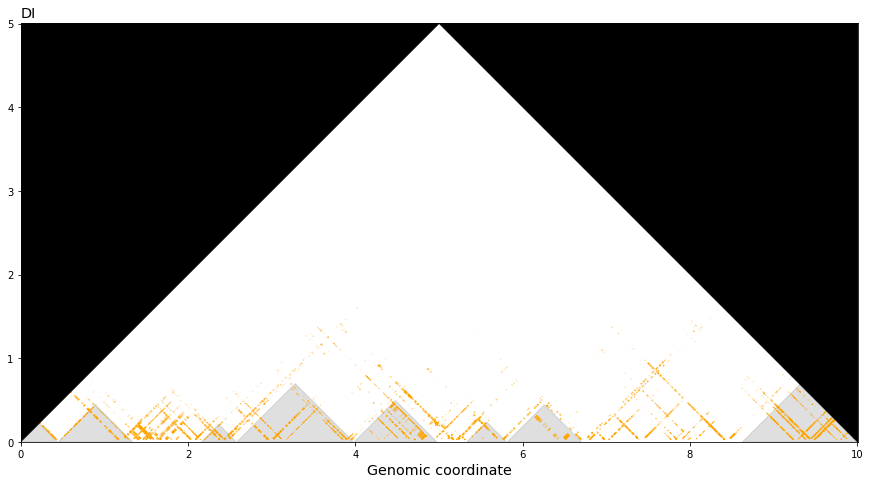

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  14.  17.  20.  25.  31.  41.  60. 414.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 12500984 max: 17497479
[INFO] Got 1176 digests
[INFO] Got 4610 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):-0.0019693805357555647
[INFO] pos_to_coordinate(end):10.005045536921383


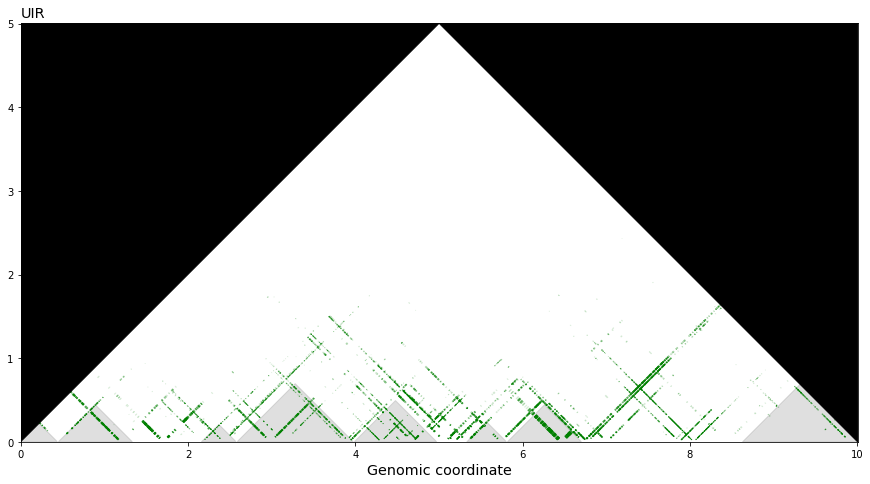

[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 17. 29.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 12507308 max: 17497479
[INFO] Got 1064 digests
[INFO] Got 2406 interactions
[INFO] begin:12500000
[INFO] end:17500000
[INFO] pos_to_coordinate(begin):-0.014644788725676936
[INFO] pos_to_coordinate(end):10.005051931086129


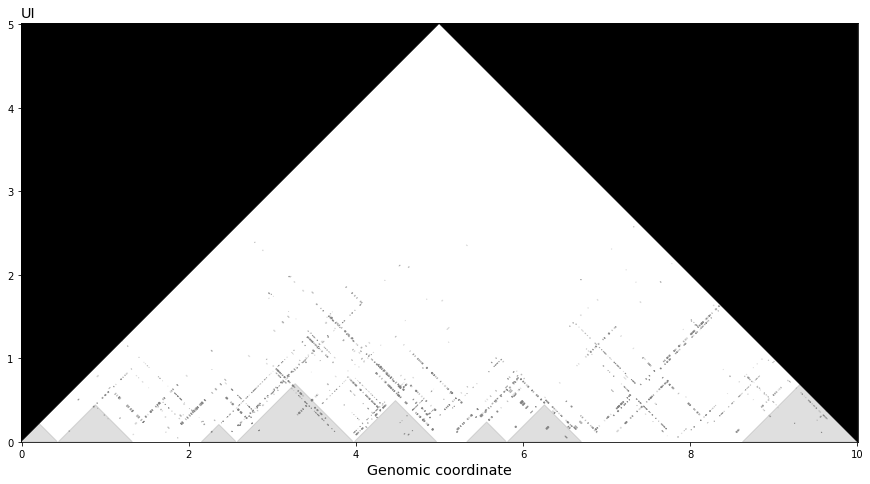

[INFO] Extracted 11238 interactions in range chr10:15000000-20000000
[INFO] Read pair count quantiles:
	[INFO] [ 46.2  57.   67.   78.   90.  107.  129.  163.  221.8 704. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 15013633 max: 19986311
[INFO] Got 653 digests
[INFO] Got 1073 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):-0.027415810957395592
[INFO] pos_to_coordinate(end):10.027528426332854


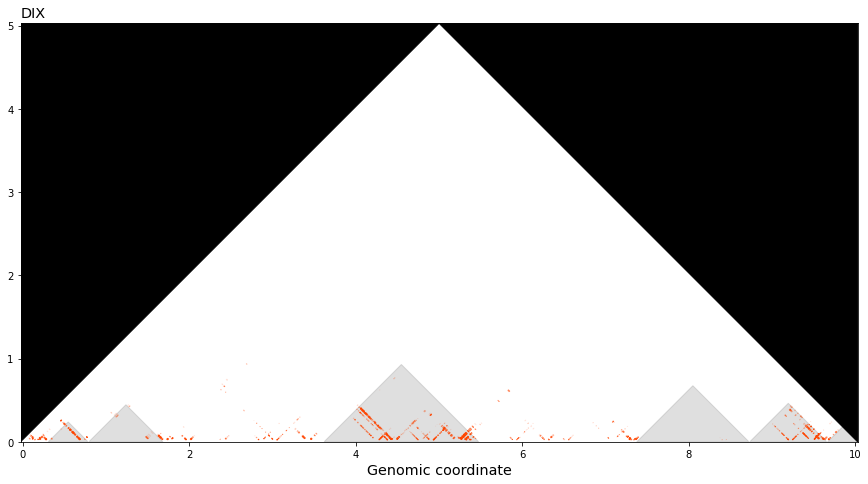

[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  27.  34.  46.  71. 538.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 15013633 max: 19997934
[INFO] Got 1212 digests
[INFO] Got 3584 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):-0.027351879431037573
[INFO] pos_to_coordinate(end):10.00414501451658


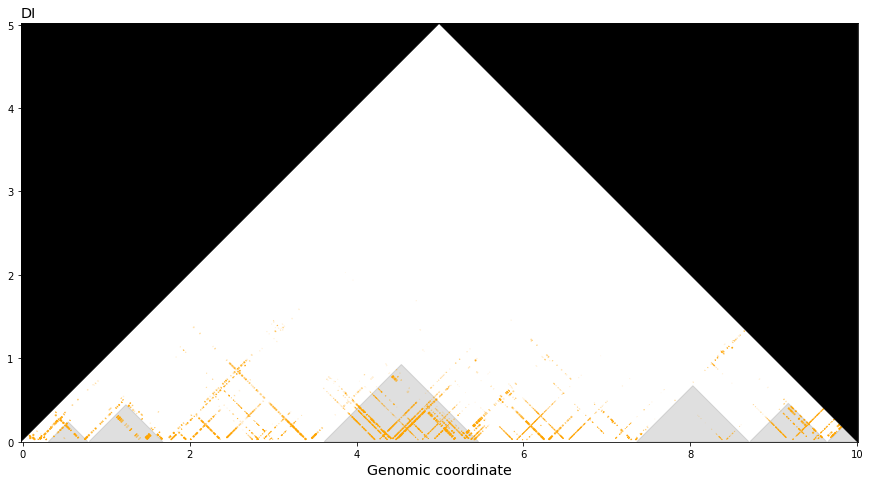

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  21.  27.  34.  44.  63. 373.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 15013633 max: 19997934
[INFO] Got 1277 digests
[INFO] Got 4387 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):-0.027351879431037573
[INFO] pos_to_coordinate(end):10.00414501451658


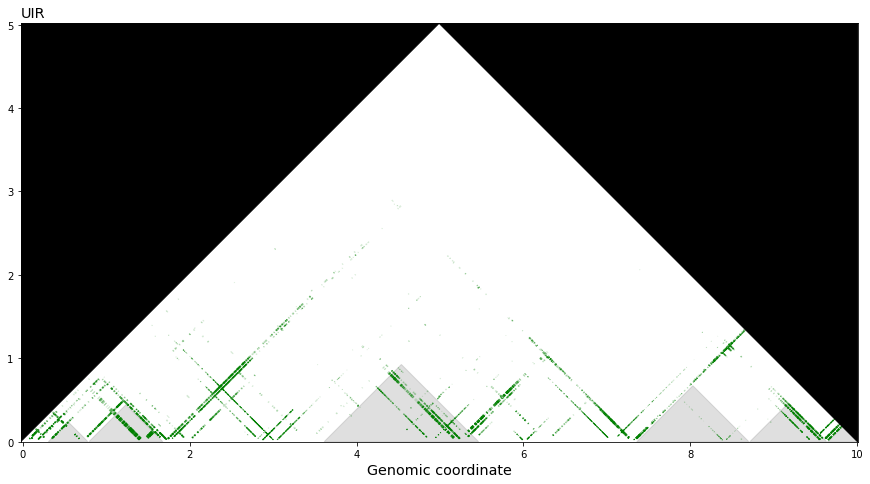

[INFO] Read pair count quantiles:
	[INFO] [ 9.  9. 10. 10. 11. 12. 13. 14. 18. 39.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 15027240 max: 19997934
[INFO] Got 1080 digests
[INFO] Got 2194 interactions
[INFO] begin:15000000
[INFO] end:20000000
[INFO] pos_to_coordinate(begin):-0.054801200798117934
[INFO] pos_to_coordinate(end):10.004156361264645


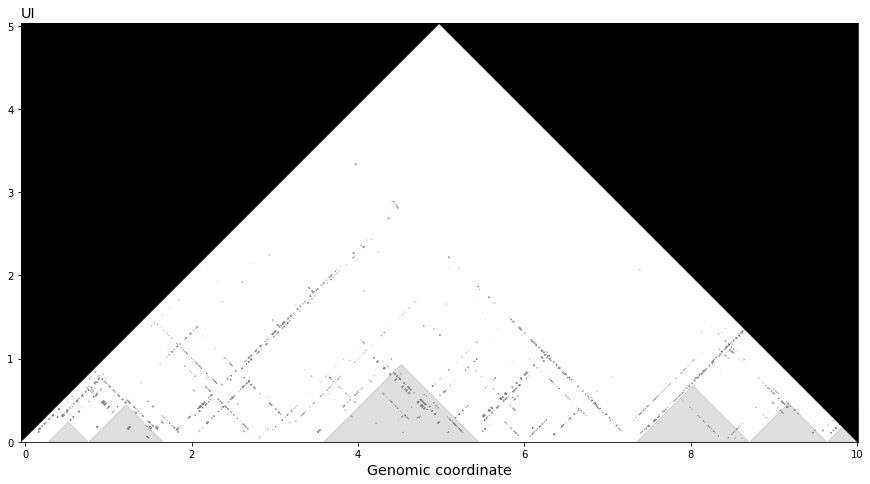

[INFO] Extracted 9159 interactions in range chr10:17500000-22500000
[INFO] Read pair count quantiles:
	[INFO] [ 45.   54.4  64.   78.   91.  110.  132.  173.6 241.3 704. ]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 17505529 max: 22498057
[INFO] Got 529 digests
[INFO] Got 788 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):-0.011074549807231928
[INFO] pos_to_coordinate(end):10.003891815929725


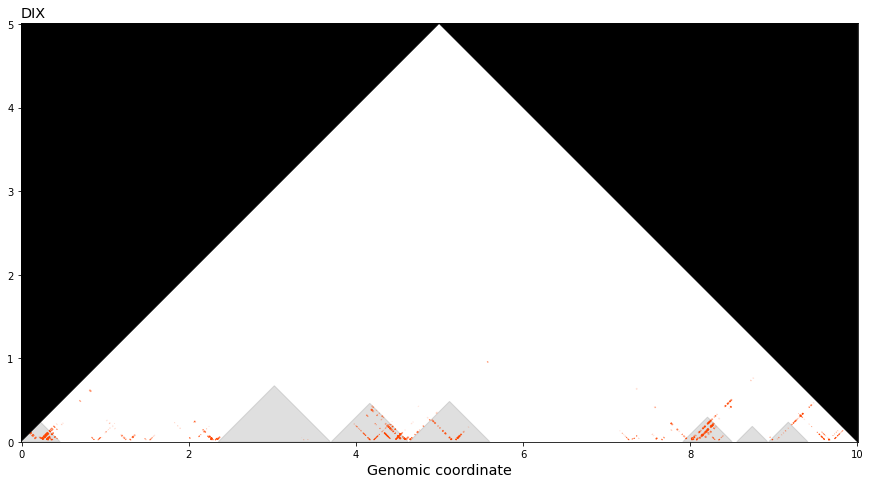

[INFO] Read pair count quantiles:
	[INFO] [ 10.  13.  15.  18.  22.  26.  33.  44.  66. 538.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 17505529 max: 22498057
[INFO] Got 1227 digests
[INFO] Got 2736 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):-0.011074549807231928
[INFO] pos_to_coordinate(end):10.003891815929725


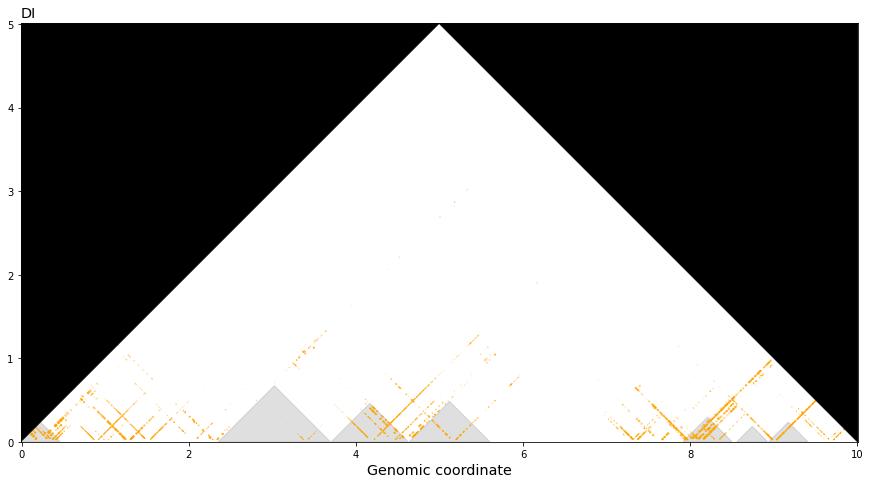

[INFO] Read pair count quantiles:
	[INFO] [ 10.  12.  15.  18.  21.  26.  33.  45.  69. 436.]
	[INFO] [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
[INFO] min: 17505529 max: 22498057
[INFO] Got 1294 digests
[INFO] Got 3795 interactions
[INFO] begin:17500000
[INFO] end:22500000
[INFO] pos_to_coordinate(begin):-0.011074549807231928
[INFO] pos_to_coordinate(end):10.003891815929725


KeyboardInterrupt: 

In [55]:
chrom = 'chr10'
for start_pos in range(5000000,100000000,2500000):
    begin = start_pos
    end = begin + 5000000
    inter_dict = visualizer.extract_interactions(chrom=chrom, begin=begin, end=end)
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DIX',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='DI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='UIR',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)
    visualizer.create_visualization(chrom=chrom,
                                begin=begin,
                                end=end,
                                inter_cat='UI',
                                enr_cat_list=['NE','EN'],
                                inter_dict=inter_dict)

In [20]:
digest_set = set()
interaction_list = []
with open('dtadvis-out.tsv') as f:
    for line in f:
        fields = line.rstrip().split('\t')
        digestA = Digest(chrom=fields[0], begin=int(fields[1]), end=int(fields[2]))
        digestB = Digest(chrom=fields[4], begin=int(fields[5]), end=int(fields[6]))
        digest_set.add(digestA)
        digest_set.add(digestB)
        statusA = fields[3] # N or E for digest A
        statusB = fields[7] # N or E for digest B
        ST = fields[8] # e.g., 2:3:1:5, read pair counts
        icat = fields[10] # interaction category, e.g. DIX, DI, etc.
        ia = Interaction(digestA=digestA, digestB=digestB, statusA=statusA, statusB=statusB, ST=ST, icat=icat)
        interaction_list.append(ia)

In [30]:
digest_list = list(digest_set)
digest_list.sort(key=lambda x: x.begin, reverse=False)
digest_min = min([x.begin for x in digest_list])
digest_max = max([x.end for x in digest_list])
digest_span = digest_max - digest_min
_factor = visualizer._figure_size / digest_span
print("[INFO] min: {} max: {}".format(_min, digest_min))
digest_to_coords = defaultdict(list)
for d in digest_list:
    digest_to_coords[d] = visualizer.digest_to_coordinates(d)
print("[INFO] Got {} digests".format(len(digest_set)))
print("[INFO] Got {} interactions".format(len(interaction_list)))

NameError: name 'digest_set' is not defined

AttributeError: 'DirectedTadVisualizer' object has no attribute '_min'

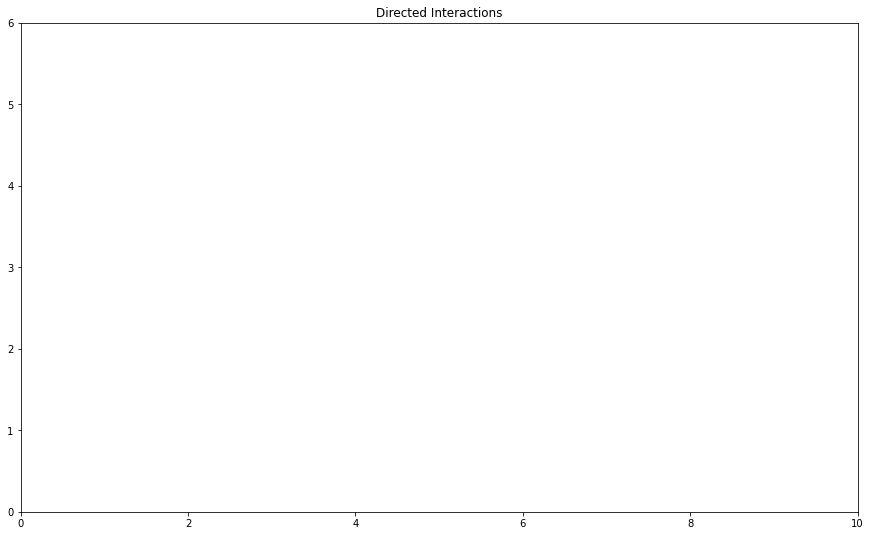

In [22]:
fig = plt.figure(1, figsize=(15, 9))
ax = fig.add_subplot(111)

ax.set_title('Directed Interactions')
xrange = [0, 10]
yrange = [0, 6]
ax.set_xlim(xrange)
ax.set_ylim(yrange)
xticks_new = []
for ia in interaction_list:
    polypatch = visualizer.interaction_to_polygon(interaction=ia, digest_to_coords=digest_to_coords)
    ax.add_patch(polypatch)
    pos = 0.5*(ia._min + ia._max) / 1000
    xticks_new.append(str(int(pos)) + ' kb')
ax.set_xticklabels(xticks_new)
        # ax.set_ylim(*yrange)
        # ax.set_yticks(range(*yrange) + [yrange[-1]])
ax.set_aspect(1)
plt.show()

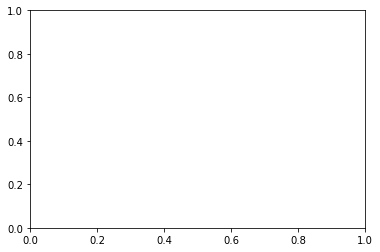

In [13]:

# return locs, labels where locs is an array of tick locations and
# labels is an array of tick labels.
locs, labels = plt.xticks()

In [14]:
labels
chrt=['a','b', 'c','d', 'e']
new_labels = [x.set_text(chrt[i]) for i,x  in enumerate(labels)]

IndexError: list index out of range

In [15]:
t = labels[0]

matplotlib.text.Text

In [16]:
t.get_text()

'a'

In [17]:
t.set_text("chr1 50kb")

In [44]:
t

Text(0.0, 0, 'chr1 50kb')